In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

In [2]:
# 데이터셋 인스턴스 생성

data = pd.read_csv('C:/USers/tisxo/AI_class/data/BP_data.csv')  # CSV 파일 경로

In [3]:
data

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,1,10.14,0.02,69,26,1,NaN,1,26118,47568,144.0,3,1,0
1996,1997,1,11.77,1.00,24,45,1,1.0,1,2572,8063,NaN,3,1,1
1997,1998,1,16.91,0.22,18,42,0,NaN,0,14933,24753,NaN,2,1,1
1998,1999,0,11.15,0.72,46,45,1,NaN,1,18157,15275,253.0,3,0,1


In [4]:
data.columns

Index(['Patient_Number', 'Blood_Pressure_Abnormality', 'Level_of_Hemoglobin',
       'Genetic_Pedigree_Coefficient', 'Age', 'BMI', 'Sex', 'Pregnancy',
       'Smoking', 'Physical_activity', 'salt_content_in_the_diet',
       'alcohol_consumption_per_day', 'Level_of_Stress',
       'Chronic_kidney_disease', 'Adrenal_and_thyroid_disorders'],
      dtype='object')

In [6]:
# 결측치 확인
print("결측치 확인 (제거 전):")
print(data.isnull().sum())

결측치 확인 (제거 전):
Patient_Number                      0
Blood_Pressure_Abnormality          0
Level_of_Hemoglobin                 0
Genetic_Pedigree_Coefficient       92
Age                                 0
BMI                                 0
Sex                                 0
Pregnancy                        1558
Smoking                             0
Physical_activity                   0
salt_content_in_the_diet            0
alcohol_consumption_per_day       242
Level_of_Stress                     0
Chronic_kidney_disease              0
Adrenal_and_thyroid_disorders       0
dtype: int64


In [7]:
data['Pregnancy'] = data['Pregnancy'].fillna(0)
# Pregancy(임신) 결측치 (NaN)을 0으로 --> 남성은 임신을 못하므로 0으로 대체한다.
data['alcohol_consumption_per_day'] = data['alcohol_consumption_per_day'].fillna(data['alcohol_consumption_per_day'].median())
# 결측치를 중앙값으로 채운다. --> 알코올 소비량은 극단적인 값이 존재하기에 평균보다 중앙값으로 대체한다.
data['Genetic_Pedigree_Coefficient'] = data['Genetic_Pedigree_Coefficient'].fillna(data['Genetic_Pedigree_Coefficient'].median())
# 유전 계수 열의 결측치를 중앙값으로 채운다. --> 0~1 사이의 실수이며, 중앙값이 이상치 영향을 덜 받기 때문에 사용한다.

In [9]:
print("결측치 확인 (제거 후):")
print(data.isnull().sum())

결측치 확인 (제거 후):
Patient_Number                   0
Blood_Pressure_Abnormality       0
Level_of_Hemoglobin              0
Genetic_Pedigree_Coefficient     0
Age                              0
BMI                              0
Sex                              0
Pregnancy                        0
Smoking                          0
Physical_activity                0
salt_content_in_the_diet         0
alcohol_consumption_per_day      0
Level_of_Stress                  0
Chronic_kidney_disease           0
Adrenal_and_thyroid_disorders    0
dtype: int64


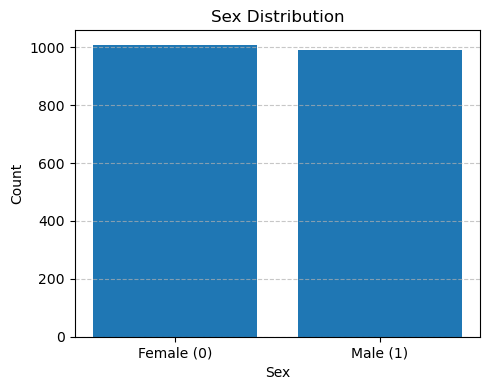

In [35]:
# 성별 분포 시각화 (0: 여성, 1: 남성으로 가정)
sex_counts = data['Sex'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(5, 4))
plt.bar(['Female (0)', 'Male (1)'], sex_counts)
plt.title('Sex Distribution')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


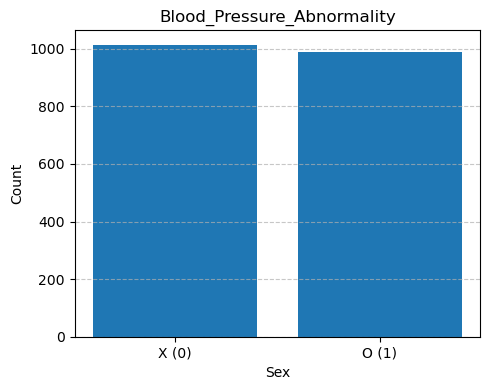

In [36]:
# 고혈압 분포 시각화 (0: 없음, 1: 있음으로 가정)
Pressure_counts = data['Blood_Pressure_Abnormality'].value_counts()

# 막대그래프 그리기
plt.figure(figsize=(5, 4))
plt.bar(['X (0)', 'O (1)'], Pressure_counts)
plt.title('Blood_Pressure_Abnormality')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


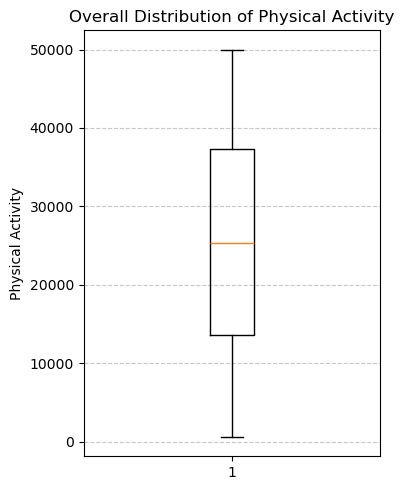

In [37]:
# Physical_activity 전체 분포 박스플롯
plt.figure(figsize=(4, 5))
plt.boxplot(data['Physical_activity'].dropna(), vert=True)

plt.title('Overall Distribution of Physical Activity')
plt.ylabel('Physical Activity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

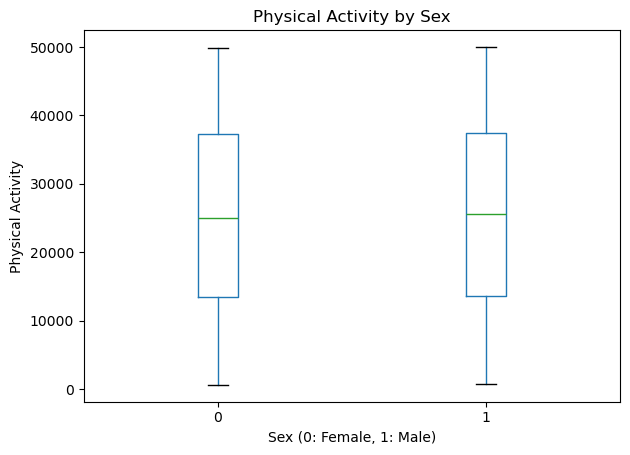

In [39]:
# 성별에 따른 Physical Activity 박스플롯
plt.figure(figsize=(6, 5))
data.boxplot(column='Physical_activity', by='Sex', grid=False)

plt.title('Physical Activity by Sex')
plt.suptitle('')  # 상단 기본 제목 제거
plt.xlabel('Sex (0: Female, 1: Male)')
plt.ylabel('Physical Activity')
plt.tight_layout()
plt.show()

C:\Users\tisxo\AppData\Local\Temp\ipykernel_9552\4011715589.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Sex', y='Physical_activity', data=data, palette='pastel')


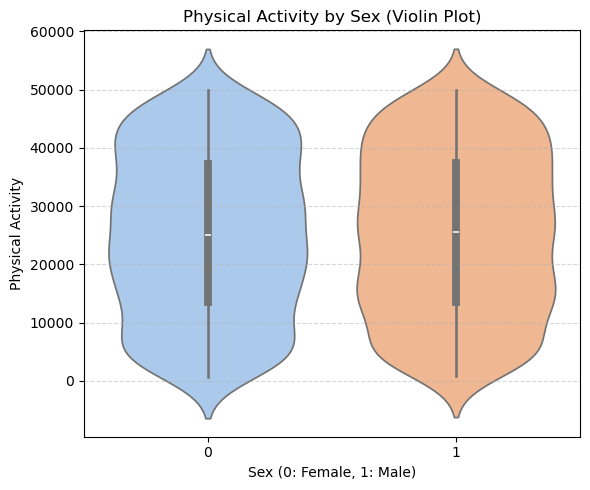

In [43]:
import seaborn as sns
# Violinplot으로 성별에 따른 Physical Activity 시각화
plt.figure(figsize=(6, 5))
sns.violinplot(x='Sex', y='Physical_activity', data=data, palette='pastel')

plt.title('Physical Activity by Sex (Violin Plot)')
plt.xlabel('Sex (0: Female, 1: Male)')
plt.ylabel('Physical Activity')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


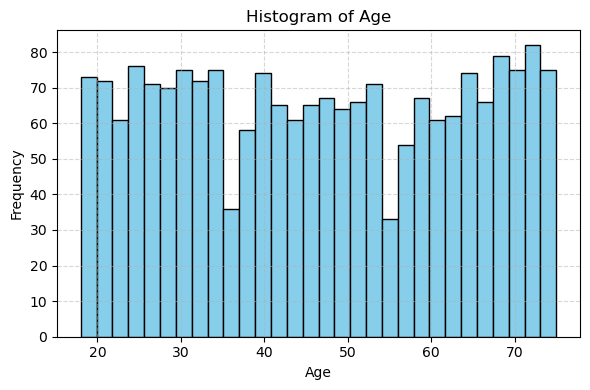

In [52]:
plt.figure(figsize=(6, 4))
plt.hist(data['Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

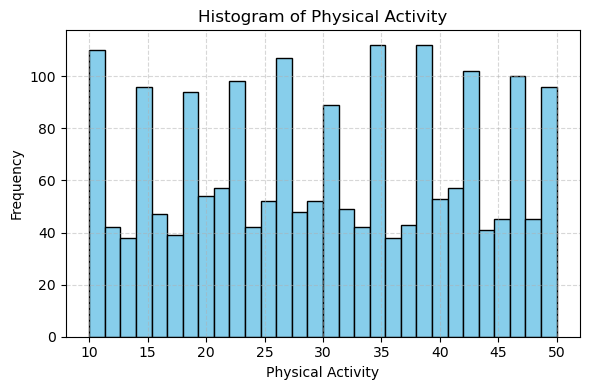

In [46]:
plt.figure(figsize=(6, 4))
plt.hist(data['BMI'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Physical Activity')
plt.xlabel('Physical Activity')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

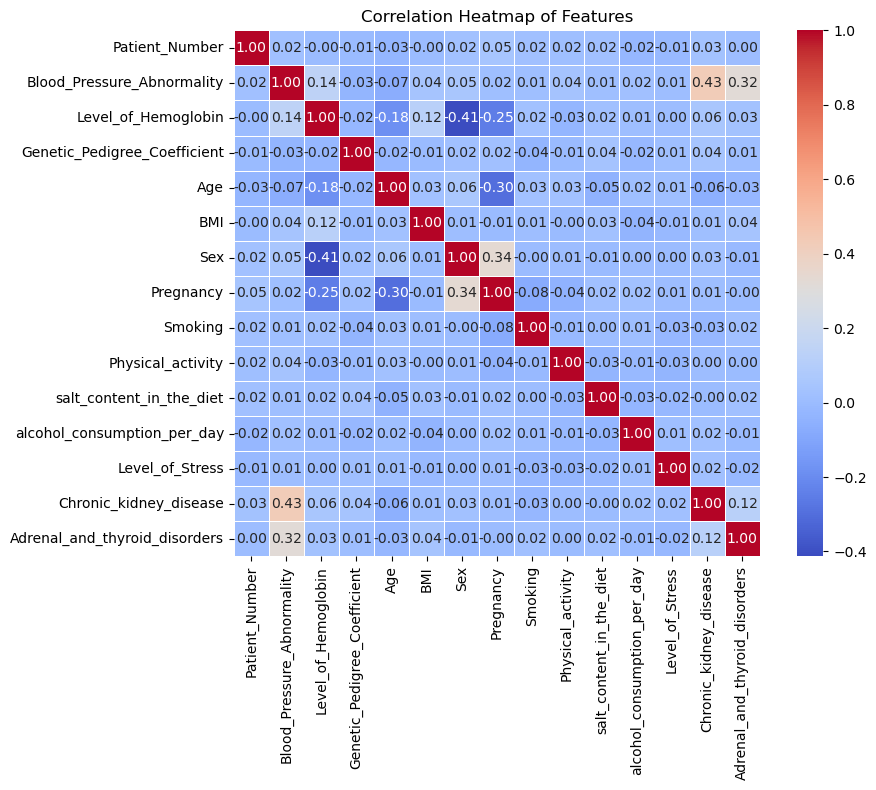

In [49]:
# 상관계수 행렬 계산
corr_matrix = data.corr(numeric_only=True)

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap of Features')
plt.tight_layout()
plt.show()

<Figure size 600x500 with 0 Axes>

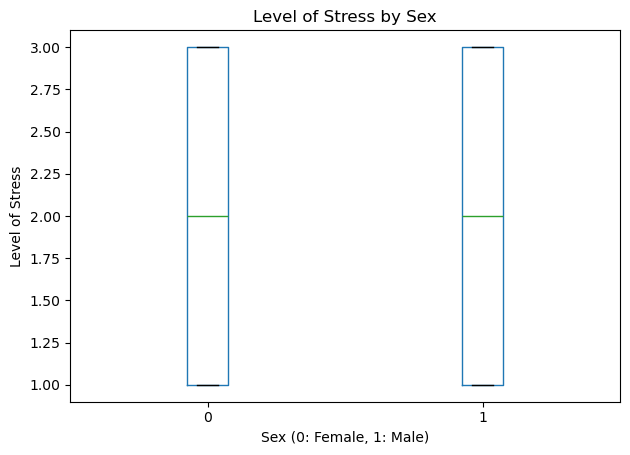

In [51]:
# 성별에 따른 스트레스 수준(Boxplot)
plt.figure(figsize=(6, 5))
data.boxplot(column='Level_of_Stress', by='Sex', grid=False)

plt.title('Level of Stress by Sex')
plt.suptitle('')  # 기본 제목 제거
plt.xlabel('Sex (0: Female, 1: Male)')
plt.ylabel('Level of Stress')
plt.tight_layout()
plt.show()


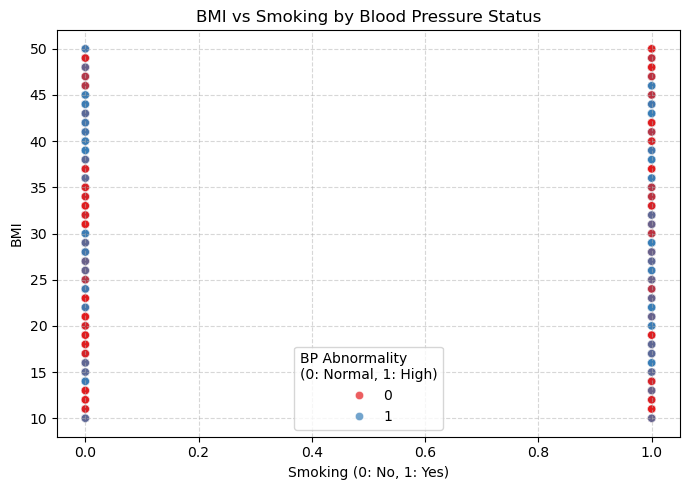

In [55]:
# 색상 구분을 위해 Blood_Pressure_Abnormality를 색으로 사용한 산점도
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x='Smoking',
    y='BMI',
    hue='Blood_Pressure_Abnormality',
    data=data,
    palette='Set1',
    alpha=0.7
)

plt.title('BMI vs Smoking by Blood Pressure Status')
plt.xlabel('Smoking (0: No, 1: Yes)')
plt.ylabel('BMI')
plt.legend(title='BP Abnormality\n(0: Normal, 1: High)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\tisxo\AppData\Local\Temp\ipykernel_9552\1704813021.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data.hist(ax=ax, bins=20, color='skyblue', edgecolor='black')


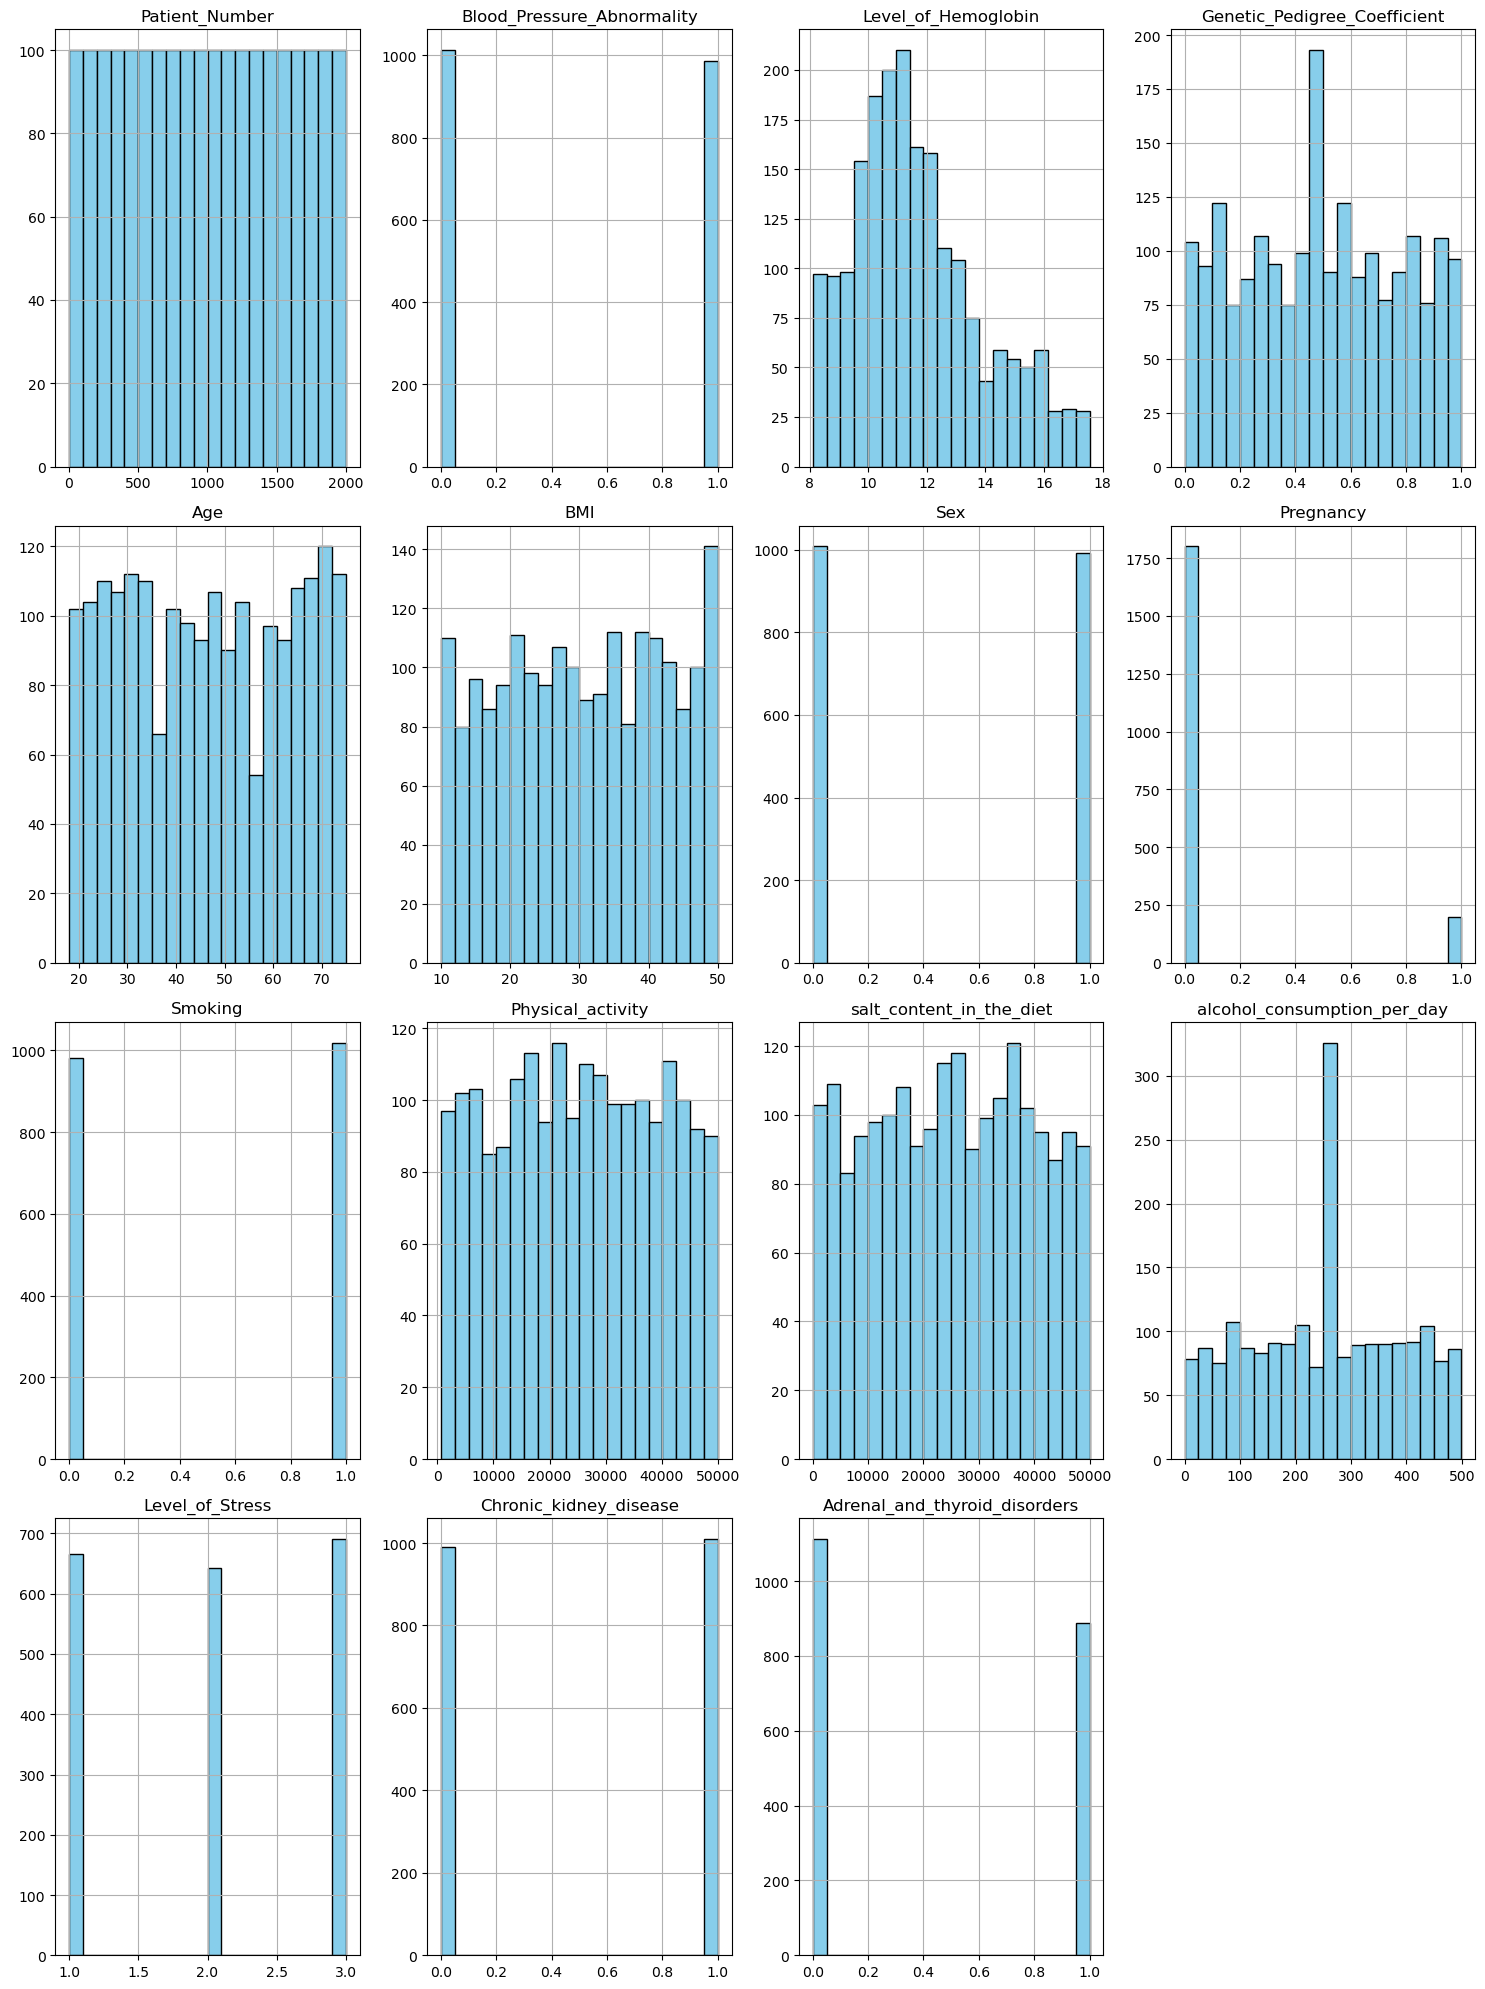

In [58]:
# 전체 수치형 컬럼에 대한 히스토그램을 한 번에 출력
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
data.hist(ax=ax, bins=20, color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [10]:
# 데이터와 타겟 분리
X = data.drop('Blood_Pressure_Abnormality', axis=1).values
y = data['Blood_Pressure_Abnormality'].values

In [11]:
# Standardize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((1600, 14), (400, 14), (1600,), (400,))

In [13]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [14]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1600, 14]),
 torch.Size([400, 14]),
 torch.Size([1600, 1]),
 torch.Size([400, 1]))

In [16]:
class DPModel(nn.Module):
    def __init__(self):
        super(DPModel, self).__init__()
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Initialize the model, loss function, and optimizer
model = DPModel()

In [18]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [19]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/20, Loss: 0.6606, Accuracy: 71.75%
Epoch 2/20, Loss: 0.5669, Accuracy: 71.00%
Epoch 3/20, Loss: 0.5109, Accuracy: 74.75%
Epoch 4/20, Loss: 0.4857, Accuracy: 76.50%
Epoch 5/20, Loss: 0.4597, Accuracy: 77.75%
Epoch 6/20, Loss: 0.4332, Accuracy: 81.25%
Epoch 7/20, Loss: 0.3996, Accuracy: 83.75%
Epoch 8/20, Loss: 0.3681, Accuracy: 86.25%
Epoch 9/20, Loss: 0.3415, Accuracy: 87.75%
Epoch 10/20, Loss: 0.3149, Accuracy: 89.00%
Epoch 11/20, Loss: 0.2989, Accuracy: 88.25%
Epoch 12/20, Loss: 0.2874, Accuracy: 88.50%
Epoch 13/20, Loss: 0.2779, Accuracy: 89.50%
Epoch 14/20, Loss: 0.2710, Accuracy: 89.50%
Epoch 15/20, Loss: 0.2619, Accuracy: 88.75%
Epoch 16/20, Loss: 0.2578, Accuracy: 90.00%
Epoch 17/20, Loss: 0.2549, Accuracy: 90.00%
Epoch 18/20, Loss: 0.2536, Accuracy: 90.00%
Epoch 19/20, Loss: 0.2480, Accuracy: 90.00%
Epoch 20/20, Loss: 0.2385, Accuracy: 89.25%
Training complete.


In [20]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        prob = torch.sigmoid(outputs)
        predicted = (prob > 0.5).int()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[186  22]
 [ 21 171]]
F1 Score: 0.89
Precision: 0.89
Recall: 0.89
Specificity: 0.89


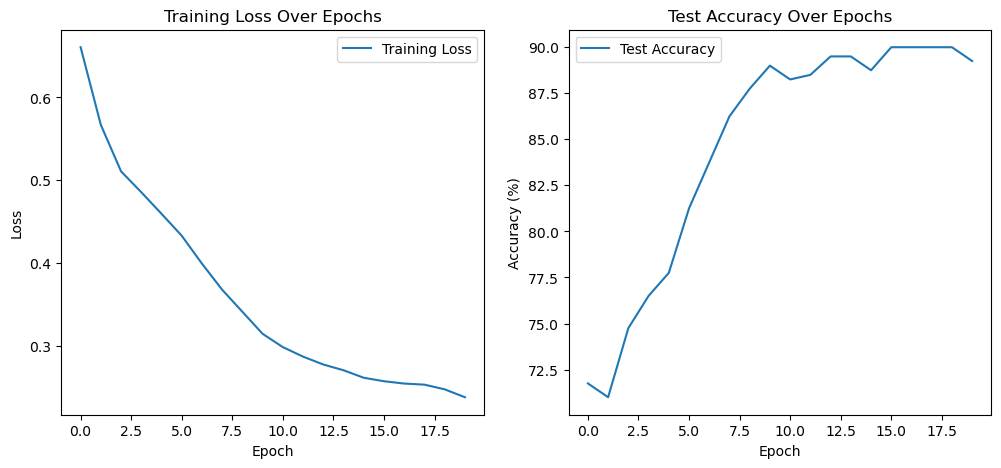

In [21]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()